In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, RobustScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import xgboost 
from sklearn import set_config
set_config(transform_output="pandas")
pd.set_option('display.max_columns', 500)



In [2]:
from db.database_mysql import engine

df = pd.read_sql_query('''SELECT jp.raw_title, 
        YEAR(jp.date) AS year, 
        MONTH(jp.date) AS month, 
        DAY(jp.date) AS day, 
        im.director, im.date,im.casting, im.distributor, im.genre, jp.country, jp.duration, jp.first_day, jp.first_week, jp.first_weekend, jp.hebdo_rank, 
jp.total_spectator, jp.copies, im.rating_press, im.budget, im.lang, im.award 
FROM films_jp as jp
LEFT JOIN films_imdb im ON im.id_jp = jp.id 
where im.id_jp is not null and im.date = jp.date
order by jp.first_week desc''', engine)

df.head(2)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[""kad merad"", ""dany boon"", ""zoe felix""]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[""josiane balasko"", ""michel blanc"", ""marieanne...","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1


In [3]:
from modelisation.functions import *

df = calculate_director_scores(df)
df = calculate_distributor_scores(df)
df = calculate_actor_scores(df)
df = calculate_year_scores(df)
df = calculate_country_scores(df)

# load_file('actor_scores')

In [4]:
# data_path = "Dataset_analyse.csv"
# df = pd.read_csv(data_path)

# # df = df.drop(['month','month_name','director_combined_score','budget','entree_annee','raw_title','actor_list','rating_press','day',"",'distributor','classification_country','country',"hebdo_rank","first_day","first_weekend","casting","award","lang"], axis=1)
# df = df.drop(['director_combined_score','year_combined_score','distributor_combined_score','entree_annee','total_actor_scores','classification_country','country_combined_score','season','month_name','is_holiday','actor_list'], axis=1)
# df = df.dropna()

# df

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


from modelisation.functions import classify_entrees_year

entree_transformer = FunctionTransformer(classify_entrees_year, kw_args={'column' : 'year'})
entree_pip = make_pipeline(entree_transformer)
entree_ct = Pipeline([('entree_dict' , entree_pip)])

entree_pipeline = make_pipeline(entree_ct)

entree_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,director_combined_score,distributor_combined_score,actor_list,actor_combined_score,year_combined_score,country_combined_score,entree_annee
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[kad merad, dany boon, zoe felix]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,0.461777,0.552991,"[""kad merad"", ""dany boon"", ""zoe felix""]",0.0,0.830920,0.716108,190.3
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[josiane balasko, michel blanc, marieanne chazel]","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,0.248820,0.341350,"[""josiane balasko"", ""michel blanc"", ""mariean...",0.0,0.855770,0.716108,188.8
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[samy naceri, frederic diefenthal, emma wiklund]","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,0.384086,0.442529,"[""samy naceri"", ""frederic diefenthal"", ""emma...",0.0,0.758796,0.716108,165.8
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[hayden christensen, natalie portman, ewan mcg...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,0.505365,0.443869,"[""hayden christensen"", ""natalie portman"", ""e...",0.0,0.816782,0.918321,175.6
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[donald glover, beyonce, seth rogen]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,0.310504,0.445801,"[""donald glover"", ""beyonce"", ""seth rogen""]",0.0,0.826926,0.918321,213.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[jules pelissier, ana girardot, audrey bastien]","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,0.114794,0.048074,"[""jules pelissier"", ""ana girardot"", ""audrey ...",0.0,0.763881,0.716108,207.1
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[michael pitt, louis garrel, eva green]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,0.145165,0.137285,"[""michael pitt"", ""louis garrel"", ""eva green""]",0.0,0.746366,0.716108,173.5
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[toni servillo, carlo verdone, sabrina ferilli]","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,0.186062,0.171407,"[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.0,0.818377,0.338789,193.7
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[valeria golino, elsa zylberstein, vincent perez]","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,0.115538,0.110157,"[""valeria golino"", ""elsa zylberstein"", ""vinc...",0.0,0.881333,0.716108,217.2


In [6]:
# from modelisation.functions import calculate_director_scores

# director_transformer = FunctionTransformer(calculate_director_scores)
# director_pip = make_pipeline(director_transformer)
# director_ct = Pipeline([('director_dict' , director_pip)])


# df = director_ct.fit_transform(df)

In [7]:
# from modelisation.functions import calculate_distributor_scores

# distributor_transformer = FunctionTransformer(calculate_distributor_scores)
# distributor_pip = make_pipeline(distributor_transformer)
# distributor_ct = Pipeline([('distributor_dict' , distributor_pip)])


# # df = distributor_ct.fit_transform(df)

In [8]:
# from modelisation.functions import calculate_year_scores

# year_transformer = FunctionTransformer(calculate_year_scores)
# year_pip = make_pipeline(year_transformer)
# year_ct = Pipeline([('year_dict' , year_pip)])


# # df = year_ct.fit_transform(df)

In [9]:
# from modelisation.functions import calculate_country_scores

# country_transformer = FunctionTransformer(calculate_country_scores)
# country_pip = make_pipeline(country_transformer)
# country_ct = Pipeline([('country_dict' , country_pip)])


# # df = country_ct.fit_transform(df)

In [10]:
from modelisation.functions import classify_season

season_transformer = FunctionTransformer(classify_season,  kw_args={'column' : 'month'})
season_pip = make_pipeline(season_transformer)
season_ct = Pipeline([('season_dict' , season_pip)])


season_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,director_combined_score,distributor_combined_score,actor_list,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[kad merad, dany boon, zoe felix]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,0.461777,0.552991,"[""kad merad"", ""dany boon"", ""zoe felix""]",0.0,0.830920,0.716108,190.3,winter
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[josiane balasko, michel blanc, marieanne chazel]","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,0.248820,0.341350,"[""josiane balasko"", ""michel blanc"", ""mariean...",0.0,0.855770,0.716108,188.8,winter
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[samy naceri, frederic diefenthal, emma wiklund]","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,0.384086,0.442529,"[""samy naceri"", ""frederic diefenthal"", ""emma...",0.0,0.758796,0.716108,165.8,spring
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[hayden christensen, natalie portman, ewan mcg...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,0.505365,0.443869,"[""hayden christensen"", ""natalie portman"", ""e...",0.0,0.816782,0.918321,175.6,spring
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[donald glover, beyonce, seth rogen]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,0.310504,0.445801,"[""donald glover"", ""beyonce"", ""seth rogen""]",0.0,0.826926,0.918321,213.2,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[jules pelissier, ana girardot, audrey bastien]","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,0.114794,0.048074,"[""jules pelissier"", ""ana girardot"", ""audrey ...",0.0,0.763881,0.716108,207.1,autumn
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[michael pitt, louis garrel, eva green]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,0.145165,0.137285,"[""michael pitt"", ""louis garrel"", ""eva green""]",0.0,0.746366,0.716108,173.5,winter
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[toni servillo, carlo verdone, sabrina ferilli]","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,0.186062,0.171407,"[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.0,0.818377,0.338789,193.7,spring
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[valeria golino, elsa zylberstein, vincent perez]","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,0.115538,0.110157,"[""valeria golino"", ""elsa zylberstein"", ""vinc...",0.0,0.881333,0.716108,217.2,summer


In [11]:
from modelisation.functions import classify_month_name

month_transformer = FunctionTransformer(classify_month_name,  kw_args={'column' : 'month'})
month_pip = make_pipeline(month_transformer)
month_ct = Pipeline([('month_dict' , month_pip)])


month_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,director_combined_score,distributor_combined_score,actor_list,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season,month_name
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[kad merad, dany boon, zoe felix]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,0.461777,0.552991,"[""kad merad"", ""dany boon"", ""zoe felix""]",0.0,0.830920,0.716108,190.3,winter,february
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[josiane balasko, michel blanc, marieanne chazel]","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,0.248820,0.341350,"[""josiane balasko"", ""michel blanc"", ""mariean...",0.0,0.855770,0.716108,188.8,winter,february
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[samy naceri, frederic diefenthal, emma wiklund]","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,0.384086,0.442529,"[""samy naceri"", ""frederic diefenthal"", ""emma...",0.0,0.758796,0.716108,165.8,spring,march
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[hayden christensen, natalie portman, ewan mcg...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,0.505365,0.443869,"[""hayden christensen"", ""natalie portman"", ""e...",0.0,0.816782,0.918321,175.6,spring,may
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[donald glover, beyonce, seth rogen]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,0.310504,0.445801,"[""donald glover"", ""beyonce"", ""seth rogen""]",0.0,0.826926,0.918321,213.2,summer,july
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[jules pelissier, ana girardot, audrey bastien]","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,0.114794,0.048074,"[""jules pelissier"", ""ana girardot"", ""audrey ...",0.0,0.763881,0.716108,207.1,autumn,september
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[michael pitt, louis garrel, eva green]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,0.145165,0.137285,"[""michael pitt"", ""louis garrel"", ""eva green""]",0.0,0.746366,0.716108,173.5,winter,december
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[toni servillo, carlo verdone, sabrina ferilli]","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,0.186062,0.171407,"[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.0,0.818377,0.338789,193.7,spring,may
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[valeria golino, elsa zylberstein, vincent perez]","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,0.115538,0.110157,"[""valeria golino"", ""elsa zylberstein"", ""vinc...",0.0,0.881333,0.7

In [12]:
from modelisation.functions import is_holiday

holiday_transformer = FunctionTransformer(is_holiday)
holiday_pip = make_pipeline(holiday_transformer)
holiday_ct = Pipeline([('holiday_dict' , holiday_pip)])


holiday_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,director_combined_score,distributor_combined_score,actor_list,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season,month_name,is_holiday
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[kad merad, dany boon, zoe felix]","[""pathe renn productions"", ""hirsch"", ""les prod...","[""comedie"", ""romantique""]",france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,0.461777,0.552991,"[""kad merad"", ""dany boon"", ""zoe felix""]",0.0,0.830920,0.716108,190.3,winter,february,0
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[josiane balasko, michel blanc, marieanne chazel]","[""les films christian fechner"", ""tf1 films pro...","[""comedie""]",france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,0.248820,0.341350,"[""josiane balasko"", ""michel blanc"", ""mariean...",0.0,0.855770,0.716108,188.8,winter,february,0
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[samy naceri, frederic diefenthal, emma wiklund]","[""arp selection"", ""canal"", ""leeloo productions""]","[""action"", ""comedie"", ""policier""]",france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,0.384086,0.442529,"[""samy naceri"", ""frederic diefenthal"", ""emma...",0.0,0.758796,0.716108,165.8,spring,march,0
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[hayden christensen, natalie portman, ewan mcg...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]","[""action"", ""aventure"", ""fantastique""]",etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,0.505365,0.443869,"[""hayden christensen"", ""natalie portman"", ""e...",0.0,0.816782,0.918321,175.6,spring,may,0
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[donald glover, beyonce, seth rogen]","[""walt disney pictures"", ""fairview entertainme...","[""animation"", ""aventure"", ""drame""]",etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,0.310504,0.445801,"[""donald glover"", ""beyonce"", ""seth rogen""]",0.0,0.826926,0.918321,213.2,summer,july,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[jules pelissier, ana girardot, audrey bastien]","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,0.114794,0.048074,"[""jules pelissier"", ""ana girardot"", ""audrey ...",0.0,0.763881,0.716108,207.1,autumn,september,0
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[michael pitt, louis garrel, eva green]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,0.145165,0.137285,"[""michael pitt"", ""louis garrel"", ""eva green""]",0.0,0.746366,0.716108,173.5,winter,december,0
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[toni servillo, carlo verdone, sabrina ferilli]","[""indigo film"", ""medusa film"", ""babe film""]","[""drame""]",italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,0.186062,0.171407,"[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.0,0.818377,0.338789,193.7,spring,may,0
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[valeria golino, elsa zylberstein, vincent perez]","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,0.115538,0.110157,"[""valeria golino"", ""elsa zylberstein

In [13]:
from modelisation.functions import nettoyer_genre

genre_transformer = FunctionTransformer(nettoyer_genre)
genre_pip = make_pipeline(genre_transformer)
genre_ct = Pipeline([('genre_dict' , genre_pip)])


genre_ct.fit_transform(df)

,raw_title,year,month,day,director,date,casting,distributor,genre,country,duration,first_day,first_week,first_weekend,hebdo_rank,total_spectator,copies,rating_press,budget,lang,award,director_combined_score,distributor_combined_score,actor_list,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season,month_name,is_holiday
0,Bienvenue chez les Ch'tis,2008,2,27,"""dany boon""",2008-02-27,"[kad merad, dany boon, zoe felix]","[""pathe renn productions"", ""hirsch"", ""les prod...",comedie,france,6360,558359,4378720,3586497,1,20489303,793,7.1,11000000,"[""francais""]",5,0.461777,0.552991,"[""kad merad"", ""dany boon"", ""zoe felix""]",0.0,0.830920,0.716108,190.3,winter,february,0
1,Les Bronzés 3: Amis pour la vie,2006,2,1,"""patrice leconte""",2006-02-01,"[josiane balasko, michel blanc, marieanne chazel]","[""les films christian fechner"", ""tf1 films pro...",comedie,france,5820,537882,3906694,3235559,1,10355930,950,-1.0,35000000,"[""anglais"", ""italien"", ""francais""]",1,0.248820,0.341350,"[""josiane balasko"", ""michel blanc"", ""mariean...",0.0,0.855770,0.716108,188.8,winter,february,0
2,Taxi 2,2000,3,29,"""gerard krawczyk""",2000-03-29,"[samy naceri, frederic diefenthal, emma wiklund]","[""arp selection"", ""canal"", ""leeloo productions""]",action,france,5400,801922,3478850,2951255,1,10345901,831,6.5,70000000,"[""francais"", ""japonais"", ""allemand""]",1,0.384086,0.442529,"[""samy naceri"", ""frederic diefenthal"", ""emma...",0.0,0.758796,0.716108,165.8,spring,march,0
3,La Revanche des Sith,2005,5,18,"""george lucas""",2005-05-18,"[hayden christensen, natalie portman, ewan mcg...","[""lucasfilm"", ""mestiere cinema"", ""pandora films""]",action,etatsunis,8760,641799,3303005,2878764,1,7247809,938,7.6,113000000,"[""anglais""]",29,0.505365,0.443869,"[""hayden christensen"", ""natalie portman"", ""e...",0.0,0.816782,0.918321,175.6,spring,may,0
4,Le Roi Lion (2019),2019,7,17,"""jon favreau""",2019-07-17,"[donald glover, beyonce, seth rogen]","[""walt disney pictures"", ""fairview entertainme...",animation,etatsunis,7080,630478,3252896,2559370,1,10017995,680,6.8,260000000,"[""anglais"", ""espagnol""]",21,0.310504,0.445801,"[""donald glover"", ""beyonce"", ""seth rogen""]",0.0,0.826926,0.918321,213.2,summer,july,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,Simon Werner a disparu,2010,9,22,"""fabrice gobert""",2010-09-22,"[jules pelissier, ana girardot, audrey bastien]","[""247 films"", ""canal"", ""cinecinema""]",None,france,5580,6351,48033,40282,15,79945,93,6.4,-1,"[""francais""]",3,0.114794,0.048074,"[""jules pelissier"", ""ana girardot"", ""audrey ...",0.0,0.763881,0.716108,207.1,autumn,september,0
2669,Innocents The Dreamers,2003,12,10,"""bernardo bertolucci""",2003-12-10,"[michael pitt, louis garrel, eva green]","[""recorded picture company rpc"", ""fiction"", ""p...",None,france,6960,7577,47922,-1,13,79849,-1,7.1,15000000,"[""anglais"", ""francais""]",2,0.145165,0.137285,"[""michael pitt"", ""louis garrel"", ""eva green""]",0.0,0.746366,0.716108,173.5,winter,december,0
2670,La Grande Bellezza,2013,5,22,"""paolo sorrentino""",2013-05-22,"[toni servillo, carlo verdone, sabrina ferilli]","[""indigo film"", ""medusa film"", ""babe film""]",drame,italie,8460,4654,47900,36844,13,198373,81,7.7,9200000,"[""italien"", ""japonais"", ""espagnol"", ""chinois""]",60,0.186062,0.171407,"[""toni servillo"", ""carlo verdone"", ""sabrina ...",0.0,0.818377,0.338789,193.7,spring,may,0
2671,Un baiser papillon,2011,6,1,"""karine silla""",2011-06-01,"[valeria golino, elsa zylberstein, vincent perez]","[""europacorp"", ""grive productions"", ""france 2 ...",None,france,6060,-1,47715,38189,14,47715,170,5.4,3500000,"[""francais""]",2,0.115538,0.110157,"[""valeria golino"", ""elsa zylberstein"", ""vinc...",0.0,0.881333,0.716108,217.2,summer,june,0


In [14]:
# from modelisation.functions import calculate_actor_scores

# actor_transformer = FunctionTransformer(calculate_actor_scores)
# actor_pip = make_pipeline(actor_transformer)
# actor_ct = Pipeline([('actor_dict' , actor_pip)])


# # df = actor_ct.fit_transform(df)

In [15]:
from modelisation.functions import drop_temp

drop_transformer = FunctionTransformer(drop_temp)
drop_pip = make_pipeline(drop_transformer)
drop_ct = Pipeline([('drop_dict' , drop_pip)])


drop_ct.fit_transform(df)

,year,date,genre,country,duration,first_week,copies,director_combined_score,distributor_combined_score,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season,month_name,is_holiday
0,2008,2008-02-27,comedie,france,6360,4378720,793,0.461777,0.552991,0.0,0.830920,0.716108,190.3,winter,february,0
1,2006,2006-02-01,comedie,france,5820,3906694,950,0.248820,0.341350,0.0,0.855770,0.716108,188.8,winter,february,0
2,2000,2000-03-29,action,france,5400,3478850,831,0.384086,0.442529,0.0,0.758796,0.716108,165.8,spring,march,0
3,2005,2005-05-18,action,etatsunis,8760,3303005,938,0.505365,0.443869,0.0,0.816782,0.918321,175.6,spring,may,0
4,2019,2019-07-17,animation,etatsunis,7080,3252896,680,0.310504,0.445801,0.0,0.826926,0.918321,213.2,summer,july,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,2010,2010-09-22,None,france,5580,48033,93,0.114794,0.048074,0.0,0.763881,0.716108,207.1,autumn,september,0
2669,2003,2003-12-10,None,france,6960,47922,-1,0.145165,0.137285,0.0,0.746366,0.716108,173.5,winter,december,0
2670,2013,2013-05-22,drame,italie,8460,47900,81,0.186062,0.171407,0.0,0.818377,0.338789,193.7,spring,may,0
2671,2011,2011-06-01,None,france,6060,47715,170,0.115538,0.110157,0.0,0.881333,0.716108,217.2,summer,june,0


In [16]:
final_pipeline = Pipeline([
    ('entree_dict' , entree_pip),
    ('season_dict' , season_pip),
    ('month_dict' , month_pip),
    ('holiday_dict' , holiday_pip),
    ('genre_dict' , genre_pip),
    ('drop_dict' , drop_pip)
    ])

df = final_pipeline.fit_transform(df)

In [17]:
# # on drop les features inutiles
# df = df.drop(['actor_list','month','day',"casting",'director','raw_title','distributor',"award","lang",'first_day','first_weekend','hebdo_rank','total_spectator','rating_press','budget'], axis=1)
df.head()

,year,date,genre,country,duration,first_week,copies,director_combined_score,distributor_combined_score,actor_combined_score,year_combined_score,country_combined_score,entree_annee,season,month_name,is_holiday
0,2008,2008-02-27,comedie,france,6360,4378720,793,0.461777,0.552991,0.0,0.830920,0.716108,190.3,winter,february,0
1,2006,2006-02-01,comedie,france,5820,3906694,950,0.248820,0.341350,0.0,0.855770,0.716108,188.8,winter,february,0
2,2000,2000-03-29,action,france,5400,3478850,831,0.384086,0.442529,0.0,0.758796,0.716108,165.8,spring,march,0
3,2005,2005-05-18,action,etatsunis,8760,3303005,938,0.505365,0.443869,0.0,0.816782,0.918321,175.6,spring,may,0
4,2019,2019-07-17,animation,etatsunis,7080,3252896,680,0.310504,0.445801,0.0,0.826926,0.918321,213.2,summer,july,1


In [18]:
# df.info()

In [19]:
X = df.drop(['first_week'], axis=1)
y = df.first_week

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42)



num_col = list(X.select_dtypes(include=[float,int]).columns)
cat_col = list(X.select_dtypes(include=[object]).columns)

# print(num_col)

onehotscale_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore', sparse_output=False), RobustScaler(with_centering=False))
scale_pipeline = make_pipeline(RobustScaler(with_centering=False))

preprocessing = ColumnTransformer(
    transformers=[
        ('categorical', onehotscale_pipeline, cat_col),
        ('numerical', scale_pipeline, num_col)]
)

polyscale_pipeline = make_pipeline(PolynomialFeatures(2))

my_final_pipeline = make_pipeline(preprocessing) #, polyscale_pipeline)
# print(X_train.columns)
my_final_pipeline.fit(X_train)
my_final_pipeline

feature_names = my_final_pipeline.get_feature_names_out(X.columns)
# print(feature_names)

In [20]:
# from sklearn import set_config


# set_config(transform_output="pandas")
# model = make_pipeline(
#     my_final_pipeline,
# )
# xdata = model.fit_transform(X_train, y_train)
# xdata.head()

In [21]:
model = make_pipeline(
    my_final_pipeline,
    xgboost.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
    )

model.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('columntransformer',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   Pipeline(steps=[('onehotencoder',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False)),
                                                                                   ('robustscaler',
                                                                                    RobustScaler(with_centering=False))]),
                                                                   ['date',
                                                                    'genre',
                                                                    'country',
                                                                    'season',
                                                                    'month_name']),
                                                                  ('numerical',
                                                                   Pipeline(steps=[('robustscal...
                              eval_metric=None, feature_types=None, gamma=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [22]:
# pyplot.bar(range(len(model[-1].feature_importances_)), model[-1].feature_importances_)
# pyplot.show()

In [23]:
# xtrain_tr = model[:-1].fit_transform(X_train)

In [24]:
# xtrain_tr.columns

In [25]:
# pd.Series(model[-1].feature_importances_, index = xtrain_tr.columns)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

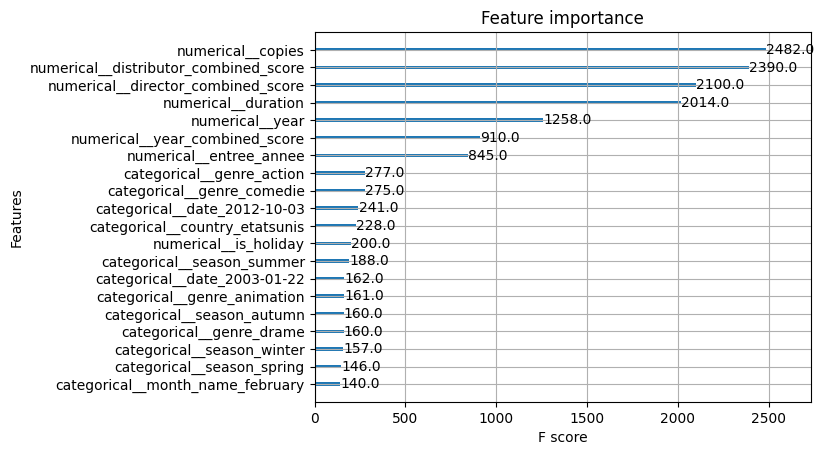

In [26]:
xgboost.plot_importance(model[-1], max_num_features=20)

In [27]:
# y_pred_train = model.predict(X_train)


# residus =  y_pred_train - y_train


# weights = np.exp(-abs(residus) / residus.std())
# model.fit(X_train, y_train, XGBRegressor__sample_weight=weights)




y_pred = model.predict(X_test)
# y_pred = model.predict(df_test)
# print(y_pred)

In [28]:

r2_cleaned = r2_score(y_test, y_pred)
mse_cleaned = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse_cleaned = np.sqrt(mse_cleaned)

print("Performance du modèle :")
# print(model.best_params_)
print(f"R2 Score: {r2_cleaned:.4f}")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse_cleaned:.2f}")

Performance du modèle :
R2 Score: 0.8968
MAE: 75651.14
RMSE: 125572.31


In [29]:
from joblib import dump, load

model_path = 'model.pkl'
dump(model, model_path)
model = load('model.pkl')

In [30]:
# def predict_prod(model,data):
#     # Convertir la liste de listes en DataFrame
#     df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
#     predictions = model.predict(df)
#     return predictions

# predict_prod(model,[[2024,'spring', 180.8,1,3, 8,2, "etatsunis",3,3, 5640, "animation", 696, 3.4, 85000000, 3]])

In [31]:
def predict_prod(model):
    # Convertir la liste de listes en DataFrame
    # df = pd.DataFrame(data, columns=['year','season', 'entree_annee','is_holiday','month','day','director', 'country','classification_country','classification_acteurs' ,'duration', 'genre', 'copies', 'rating_press','budget','distributor'])
    data_leroy = {
    'year': [2024],
    'duration': [6120],
    'date': ['10-04-2024'],
    'country': ['france'],
    'copies': [414],
    'genre': ['comedie'],
    'entree_annee': [180.8],
    'season': ['spring'],
    'month_name': ['april'],
    'is_holiday': [0],
    'director_combined_score': [0.3],
    'actor_combined_score': [0.9],
    'distributor_combined_score': [0],
    'year_combined_score': [0.440816],
    'country_combined_score': [0.716108]
}
    
    data_sos = {
    'year': [2024],
    'duration': [6960],
    'date': ['10-04-2024'],
    'country': ['etatsunis'],
    'copies': [670],
    'genre': ['aventure'],
    'entree_annee': [180.8],
    'season': ['spring'],
    'month_name': ['april'],
    'is_holiday': [0],
    'director_combined_score': [0],
    'actor_combined_score': [0],
    'distributor_combined_score': [0],
    'year_combined_score': [0.440816],
    'country_combined_score': [0.918321]
}

    data_leroy = pd.DataFrame(data_leroy)
    data_sos = pd.DataFrame(data_sos)
    predictions = model.predict(data_leroy)
    return predictions

predict_prod(model)

array([62399.523], dtype=float32)